# Multi-Class Image Classification Model for Kannada Handwritten Digits Using TensorFlow Take 3
### David Lowe
### December 31, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Kannada Handwritten Digits dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: Kannada is a language spoken predominantly by the people of Karnataka in southwestern India. The language has roughly 45 million native speakers and is written using the Kannada script. This modeling project uses the same format as the MNIST dataset regarding how the data is structured. All details of the dataset curation have been captured in the paper titled: Prabhu, Vinay Uday. "Kannada-MNIST: A new handwritten digits dataset for the Kannada language." arXiv preprint arXiv:1908.01242 (2019) https://arxiv.org/abs/1908.01242

From iteration Take1, we constructed a simple three-layer CNN neural network to use as the baseline model for analyzing this dataset.

From iteration Take2, we constructed a four-layer CNN neural network to use as the baseline model for analyzing this dataset.

In this Take3 iteration, we will construct a five-layer CNN neural network to use as the baseline model for analyzing this dataset.

ANALYSIS: From iteration Take1, the baseline model's performance achieved an average accuracy score of 99.48% after ten epochs using the training dataset. After trying out different hyperparameters sets, the best model processed Kaggle's public test dataset with an accuracy score of 97.90%. Furthermore, the final model processed Kaggle's unseen test dataset with an accuracy measurement of 97.74%.

From iteration Take2, the four-layer model's performance achieved an average accuracy score of 99.49% after ten epochs using the training dataset. After trying out different hyperparameters sets, the best model processed Kaggle's public test dataset with an accuracy score of 98.24%. Furthermore, the final model processed Kaggle's unseen test dataset with an accuracy measurement of 97.80%.

In this Take3 iteration, the five-layer model's performance achieved an average accuracy score of 99.52% after ten epochs using the training dataset. After trying out different hyperparameters sets, the best model processed Kaggle's public test dataset with an accuracy score of 98.08%. Furthermore, the final model processed Kaggle's unseen test dataset with an accuracy measurement of 97.74%.

CONCLUSION: In this iteration, the TensorFlow CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: Kannada Handwritten Digits Dataset

Dataset ML Model: Multi-class image classification with numerical attributes

Dataset Reference: https://www.kaggle.com/c/Kannada-MNIST/overview

One potential source of performance benchmarks: https://www.kaggle.com/c/Kannada-MNIST/leaderboard

A deep-learning modeling project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images 
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [51]:
# Install the packages to support accessing environment variable and SQL databases
!pip install python-dotenv PyMySQL boto3

In [52]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Dec 16 19:31:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    37W / 300W |   2911MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [53]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [54]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


## 1.a) Load libraries and modules

In [55]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [56]:
# Load libraries and packages
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
# import boto3
# import zipfile
from datetime import datetime
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [57]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
TEST_SET_SIZE = 0.2
VAL_SET_SIZE = 0.2

# Set the number of folds and iterations for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_INITIALIZER = tf.keras.initializers.GlorotUniform(seed=RNG_SEED)
DEFAULT_EPOCH = 20
DEFAULT_BATCH = 32
IMAGE_SHAPE = (28, 28, 1)
NUM_CLASSES = 10

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.3.0


In [58]:
# Set up the parent directory location for loading the dotenv files
# # Mount Google Drive locally for storing files
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# env_path = "/Users/david/PycharmProjects/"
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

In [59]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [60]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [61]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [62]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [63]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## 2.a) Load Dataset

In [64]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-kannada-handwritten-digits/train.csv'
Xy_original = pd.read_csv(dataset_path, sep=',')
print('Number of records loaded into the dataframe:', len(Xy_original))

Number of records loaded into the dataframe: 60000


In [65]:
# Take a peek at the dataframe after the import
print(Xy_original.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  \
0      0       0       0       0       0       0       0       0       0       0  ...         0         0         0         0         0   
1      1       0       0       0       0       0       0       0       0       0  ...         0         0         0         0         0   
2      2       0       0       0       0       0       0       0       0       0  ...         0         0         0         0         0   
3      3       0       0       0       0       0       0       0       0       0  ...         0         0         0         0         0   
4      4       0       0       0       0       0       0       0       0       0  ...         0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0         0  
1         0         0         0         0         0  
2  

In [66]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 359.3 MB


In [67]:
print(Xy_original.describe())

              label   pixel0   pixel1   pixel2   pixel3   pixel4        pixel5        pixel6        pixel7        pixel8  ...  \
count  60000.000000  60000.0  60000.0  60000.0  60000.0  60000.0  60000.000000  60000.000000  60000.000000  60000.000000  ...   
mean       4.500000      0.0      0.0      0.0      0.0      0.0      0.008817      0.029467      0.037767      0.075933  ...   
std        2.872305      0.0      0.0      0.0      0.0      0.0      1.474271      2.700491      2.726371      3.993023  ...   
min        0.000000      0.0      0.0      0.0      0.0      0.0      0.000000      0.000000      0.000000      0.000000  ...   
25%        2.000000      0.0      0.0      0.0      0.0      0.0      0.000000      0.000000      0.000000      0.000000  ...   
50%        4.500000      0.0      0.0      0.0      0.0      0.0      0.000000      0.000000      0.000000      0.000000  ...   
75%        7.000000      0.0      0.0      0.0      0.0      0.0      0.000000      0.000000     

In [68]:
# Surface the features that have NaNs
null_counts = Xy_original.isnull().sum()
if null_counts.sum() > 0 :
    print(null_counts[null_counts > 0])
print('Total number of NaN in the dataframe:', null_counts.sum())

Total number of NaN in the dataframe: 0


## 2.b) Splitting Data into Sets

In [69]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = 1

In [70]:
# We create attribute-only and target-only datasets
if targetCol == totCol:
    X_train_df = Xy_original.iloc[:,0:totAttr]
    y_train_df = Xy_original.iloc[:,totAttr]
else:
    X_train_df = Xy_original.iloc[:,1:totCol]
    y_train_df = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_train_df.shape: {} y_train_df.shape: {}".format(Xy_original.shape, X_train_df.shape, y_train_df.shape))

Xy_original.shape: (60000, 785) X_train_df.shape: (60000, 784) y_train_df.shape: (60000,)


### 2.c) Feature Scaling and Image Preview

In [71]:
# Normalize the data to reduce the effect of illumination's differences and help the CNN converges faster
X_train = X_train_df.to_numpy()
X_train = X_train / 255
print('X_train.shape:', X_train.shape)

X_train.shape: (60000, 784)


In [72]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
X_train = X_train.reshape(-1, 28, 28, 1)
print('X_train.shape:', X_train.shape)

X_train.shape: (60000, 28, 28, 1)


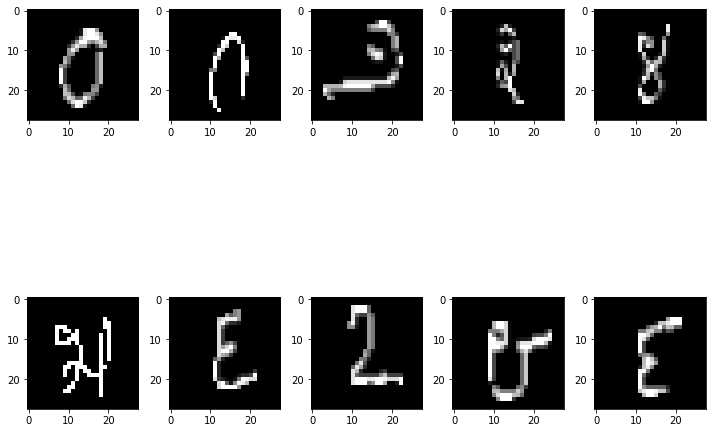

In [73]:
# Spot-checking the first 10 training images
f, ax = plt.subplots(2, 5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(X_train[k].reshape(28, 28) , cmap="gray")
        k += 1
plt.tight_layout()
plt.show()

In [74]:
print(y_train_df[:10])

0    0
1    1
2    2
3    3
4    4
5    5
6    6
7    7
8    8
9    9
Name: label, dtype: int64


### 2.d) Display the Final Datasets for Model-Building

In [75]:
# Finalize the training dataset for the modeling activities
class_encoder = preprocessing.LabelBinarizer()
y_train = class_encoder.fit_transform(y_train_df)
print('X_train.shape: {} y_train.shape: {}'.format(X_train.shape, y_train.shape))

X_train.shape: (60000, 28, 28, 1) y_train.shape: (60000, 10)


In [76]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [77]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [78]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=IMAGE_SHAPE, output_param=NUM_CLASSES, conv1_filters=512, conv2_filters=384, conv3_filters=256, conv4_filters=128, conv5_filters=64,
                    conv1_dropout=0, conv2_dropout=0, conv3_dropout=0, conv4_dropout=0, conv5_dropout=0, dense_nodes=2048, dense_dropout=0, 
                    init_param=DEFAULT_INITIALIZER, loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metric_param=DEFAULT_METRICS):
    nn_model = keras.Sequential([
        # This is the first convolution
        keras.layers.Conv2D(conv1_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param, input_shape=input_param),
        keras.layers.Dropout(conv1_dropout),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2), strides=2, padding='same'),
        # This is the second convolution
        keras.layers.Conv2D(conv2_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(conv2_dropout),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2), strides=2, padding='same'),
        # This is the third convolution
        keras.layers.Conv2D(conv3_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(conv3_dropout),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2), strides=2, padding='same'),
        # This is the fourth convolution
        keras.layers.Conv2D(conv4_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(conv4_dropout),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2), strides=2, padding='same'),
        # This is the fifth convolution
        keras.layers.Conv2D(conv5_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(conv5_dropout),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2), strides=2, padding='same'),
        # Flatten the results to feed into a DNN
        keras.layers.Flatten(),
        keras.layers.Dense(dense_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(dense_dropout),
        keras.layers.Dense(output_param, activation='softmax', kernel_initializer=init_param)
    ])
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metric_param)
    return nn_model

In [79]:
# Initialize the default model and get a baseline result
startTimeModule = datetime.now()
results = list()
iteration = 0
cv = RepeatedKFold(n_splits=N_FOLDS, n_repeats=N_ITERATIONS, random_state=RNG_SEED)
for train_ix, val_ix in cv.split(X_train):
    feature_train, feature_validation = X_train[train_ix], X_train[val_ix]
    target_train, target_validation = y_train[train_ix], y_train[val_ix]
    reset_random()
    baseline_model = create_nn_model()
    baseline_model.fit(feature_train, target_train, epochs=DEFAULT_EPOCH, batch_size=DEFAULT_BATCH, verbose=1)
    model_metric = baseline_model.evaluate(feature_validation, target_validation, verbose=0)[1]
    iteration = iteration + 1
    print('Accuracy measurement from iteration %d >>> %.2f%%\n' % (iteration, model_metric*100))
    results.append(model_metric)
validation_score = np.mean(results)
validation_variance = np.std(results)
print('Average model accuracy from all iterations: %.2f%% (%.2f%%)' % (validation_score*100, validation_variance*100))
print('Total time for model fitting and cross validating:', (datetime.now() - startTimeModule))

Epoch 1/20
1500/1500 [==============================] - 13s 8ms/step - loss: 0.0778 - accuracy: 0.9772
Epoch 2/20
1500/1500 [==============================] - 13s 8ms/step - loss: 0.0353 - accuracy: 0.9898
Epoch 3/20
1500/1500 [==============================] - 13s 8ms/step - loss: 0.0263 - accuracy: 0.9927
Epoch 4/20
1500/1500 [==============================] - 13s 8ms/step - loss: 0.0230 - accuracy: 0.9933
Epoch 5/20
1500/1500 [==============================] - 13s 8ms/step - loss: 0.0186 - accuracy: 0.9949
Epoch 6/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0139 - accuracy: 0.9957
Epoch 7/20
1500/1500 [==============================] - 13s 8ms/step - loss: 0.0154 - accuracy: 0.9958
Epoch 8/20
1500/1500 [==============================] - 13s 8ms/step - loss: 0.0089 - accuracy: 0.9977
Epoch 9/20
1500/1500 [==============================] - 13s 8ms/step - loss: 0.0115 - accuracy: 0.9969
Epoch 10/20
1500/1500 [==============================] - 12s 8ms/step - l

In [80]:
baseline_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 28, 28, 512)       5120      
_________________________________________________________________
dropout_90 (Dropout)         (None, 28, 28, 512)       0         
_________________________________________________________________
batch_normalization_75 (Batc (None, 28, 28, 512)       2048      
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 14, 14, 384)       1769856   
_________________________________________________________________
dropout_91 (Dropout)         (None, 14, 14, 384)       0         
_________________________________________________________________
batch_normalization_76 (Batc (None, 14, 14, 384)     

In [81]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [82]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [83]:
# Initialize an alternate model to compare with the baseline result
startTimeModule = datetime.now()
results = list()
iteration = 0
cv = RepeatedKFold(n_splits=N_FOLDS, n_repeats=N_ITERATIONS, random_state=RNG_SEED)
for train_ix, val_ix in cv.split(X_train):
    feature_train, feature_validation = X_train[train_ix], X_train[val_ix]
    target_train, target_validation = y_train[train_ix], y_train[val_ix]
    reset_random()
    alternate_model = create_nn_model(conv1_dropout=0.25, conv2_dropout=0.25, conv3_dropout=0.25, conv4_dropout=0.25, conv5_dropout=0.25, dense_dropout=0.25)
    alternate_model.fit(feature_train, target_train, epochs=DEFAULT_EPOCH, batch_size=DEFAULT_BATCH, verbose=1)
    model_metric = alternate_model.evaluate(feature_validation, target_validation, verbose=0)[1]
    iteration = iteration + 1
    print('Accuracy measurement from iteration %d >>> %.2f%%\n' % (iteration, model_metric*100))
    results.append(model_metric)
validation_score = np.mean(results)
validation_variance = np.std(results)
print('Average model accuracy from all iterations: %.2f%% (%.2f%%)' % (validation_score*100, validation_variance*100))
print('Total time for model fitting and cross validating:', (datetime.now() - startTimeModule))

Epoch 1/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.1241 - accuracy: 0.9606
Epoch 2/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0429 - accuracy: 0.9875
Epoch 3/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0346 - accuracy: 0.9901
Epoch 4/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0310 - accuracy: 0.9910
Epoch 5/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0258 - accuracy: 0.9929
Epoch 6/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0241 - accuracy: 0.9930
Epoch 7/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0203 - accuracy: 0.9943
Epoch 8/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0171 - accuracy: 0.9952
Epoch 9/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0177 - accuracy: 0.9950
Epoch 10/20
1500/1500 [==============================] - 13s 9ms/step - l

In [ ]:
alternate_model.summary()

In [ ]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [ ]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

### 5.a) Load the Test Dataset

In [ ]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-kannada-handwritten-digits/test.csv'
X_test_df = pd.read_csv(dataset_path, sep=',')
print('Number of records loaded into the dataframe:', len(X_test_df))

In [88]:
# Take a peek at the dataframe after the import
print(X_test_df.head())

   id  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  \
0   0       0       0       0       0       0       0       0       0       0  ...         0         0         0         0         0   
1   1       0       0       0       0       0       0       0       0       0  ...         0         0         0         0         0   
2   2       0       0       0       0       0       0       0       0       0  ...         0         0         0         0         0   
3   3       0       0       0       0       0       0       0       0       0  ...         0         0         0         0         0   
4   4       0       0       0       0       0       0       0       0       0  ...         0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0         0  
1         0         0         0         0         0  
2         0         0

In [89]:
X_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 785 entries, id to pixel783
dtypes: int64(785)
memory usage: 29.9 MB


In [90]:
print(X_test_df.describe())

                id  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7      pixel8  ...     pixel774     pixel775  \
count  5000.000000  5000.0  5000.0  5000.0  5000.0  5000.0  5000.0  5000.0  5000.0  5000.00000  ...  5000.000000  5000.000000   
mean   2499.500000     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.04780  ...     0.191600     0.112600   
std    1443.520003     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     3.37997  ...     6.077753     4.859161   
min       0.000000     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.00000  ...     0.000000     0.000000   
25%    1249.750000     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.00000  ...     0.000000     0.000000   
50%    2499.500000     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.00000  ...     0.000000     0.000000   
75%    3749.250000     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.00000  .

In [91]:
# Surface the features that have NaNs
null_counts = X_test_df.isnull().sum()
if null_counts.sum() > 0 :
    print(null_counts[null_counts > 0])
print('Total number of NaN in the dataframe:', null_counts.sum())

Total number of NaN in the dataframe: 0


In [92]:
# Set up the dataframe to capture predictions for Kaggle submission
y_submission_kaggle = pd.DataFrame(columns=['id', 'label'])
y_submission_kaggle['id'] = X_test_df['id']
X_test_df.drop(columns=['id'], inplace=True)
print(y_submission_kaggle.head())

   id label
0   0   NaN
1   1   NaN
2   2   NaN
3   3   NaN
4   4   NaN


In [93]:
# Normalize the data to reduce the effect of illumination's differences and help the CNN converges faster
X_test = X_test_df.to_numpy()
X_test = X_test / 255
print('X_test.shape:', X_test.shape)

X_test.shape: (5000, 784)


In [94]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
X_test = X_test.reshape(-1, 28, 28, 1)
print('X_test.shape:', X_test.shape)

X_test.shape: (5000, 28, 28, 1)


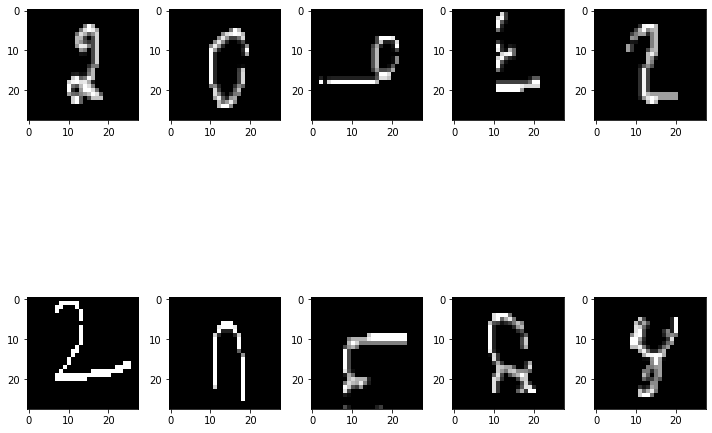

In [95]:
# Spot-checking the first 10 training images
f, ax = plt.subplots(2, 5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(X_test[k].reshape(28, 28) , cmap="gray")
        k += 1
plt.tight_layout()
plt.show()

### 5.b) Train the Final Model and Make Predictions

In [96]:
reset_random()
final_model = create_nn_model()
final_model.fit(X_train, y_train, epochs=DEFAULT_EPOCH, batch_size=DEFAULT_BATCH, verbose=1)

Epoch 1/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0760 - accuracy: 0.9772
Epoch 2/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0289 - accuracy: 0.9916
Epoch 3/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0232 - accuracy: 0.9934
Epoch 4/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0190 - accuracy: 0.9945
Epoch 5/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0157 - accuracy: 0.9955
Epoch 6/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0129 - accuracy: 0.9962
Epoch 7/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0105 - accuracy: 0.9973
Epoch 8/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0103 - accuracy: 0.9973
Epoch 9/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0101 - accuracy: 0.9974
Epoch 10/20
1875/1875 [==============================] - 16s 8ms/step - l

In [ ]:
test_predictions = np.argmax(final_model.predict(X_test), axis=-1)
y_submission_kaggle['label'] = test_predictions
print("y_submission_kaggle.shape: {}".format(y_submission_kaggle.shape))
print(test_predictions[:10])

In [ ]:
submission_file = y_submission_kaggle.to_csv(header=True, index=False)
filename = 'submission.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

In [ ]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [100]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:49:12.633414
